In [65]:
# Section 1: Imports
import os  # To work with file system paths
from typing import List, Dict  # For type hinting
from jiwer import wer, cer  # To calculate WER and CER
import matplotlib.pyplot as plt  # For plotting the boxplots
from scipy.stats import ttest_ind, mannwhitneyu, shapiro  # For statistical tests
import numpy as np  # For numerical operations

# Section 2: Functions for WER and CER Calculation
def read_file(filepath: str) -> str:
    """Reads the content of a text file and returns it as a string."""
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().strip()

def extract_id_and_keyword(filename: str) -> (str, str):
    """Extracts the patient ID and keyword from the filename."""
    for separator in ['_', '-']:
        if separator in filename:
            return filename.split(separator, 1)[0], filename.split(separator, 1)[1].replace('.txt', '')
    return None, None

# Reference sentences associated with each keyword
keyword_phrases = {
    'juan': 'Juan se rompió una pierna cuando iba en la moto',
    'loslibros': 'Los libros nuevos no caben en la mesa de la oficina',
    'laura': 'Laura sube al tren que pasa',
    'luisa': 'Luisa Rey compra el colchón duro que tanto le gusta',
    'micasa': 'Mi casa tiene tres cuartos',
    'omar': 'Omar, que vive cerca, trajo miel',
    'preocupado': 'Estoy muy preocupado, cada vez me es más difícil hablar',
    'rosita': 'Rosita Niño, que pinta bien, donó sus cuadros ayer',
    'triste': 'Estoy muy triste, ayer vi morir a un amigo',
    'viste': '¿Viste las noticias? Yo vi ganar la medalla di plata en pesas. Ese muchacho tiene molta forza!',
    'readtext': 'Ayer fui al médico. ¿Qué le pasa? Me preguntó. Yo le dije: ¡Ay doctor! Donde pongo el dedo me duele. ¿Tiene la una rota? Sí. Pues ya sabemos qué es. Deje su cheque a la salida.'
}

def calculate_wer_cer_for_files(directory: str, control_ids: List[str], parkinsonian_ids: List[str]) -> Dict[str, List[float]]:
    """Calculates WER and CER for files and returns values for controls and Parkinsonians."""
    control_wer = []  # To store WER values for control subjects
    parkinsonian_wer = []  # To store WER values for Parkinsonian subjects
    control_cer = []  # To store CER values for control subjects
    parkinsonian_cer = []  # To store CER values for Parkinsonian subjects
    
    # List of files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    
    # Iterate over the files
    for file in files:
        file_id, keyword = extract_id_and_keyword(file)
        
        if not file_id or not keyword:
            print(f"File '{file}' does not follow the expected format 'ID_keyword.txt' or 'ID-keyword.txt'")
            continue
        
        # Verify if the keyword is valid
        if keyword not in keyword_phrases:
            print(f"Keyword '{keyword}' not recognized in the file '{file}'")
            continue
        
        file_path = os.path.join(directory, file)
        reference = keyword_phrases[keyword]
        hypothesis = read_file(file_path)
        
        # Calculate WER and CER and append to the appropriate list
        if file_id in control_ids:
            control_wer.append(wer(reference, hypothesis))
            control_cer.append(cer(reference, hypothesis))
        elif file_id in parkinsonian_ids:
            parkinsonian_wer.append(wer(reference, hypothesis))
            parkinsonian_cer.append(cer(reference, hypothesis))
    
    return {
        'control_wer': control_wer,
        'parkinsonian_wer': parkinsonian_wer,
        'control_cer': control_cer,
        'parkinsonian_cer': parkinsonian_cer
    }



In [66]:
# Section 4: Perform Statistical Tests (Shapiro-Wilk, Mann-Whitney U, or t-test)
def perform_statistical_tests(control_values, parkinsonian_values, metric_name):
    """Performs Shapiro-Wilk test for normality and applies the appropriate statistical test."""

    # Shapiro-Wilk test for normality
    control_normality_p = shapiro(control_values).pvalue
    parkinsonian_normality_p = shapiro(parkinsonian_values).pvalue
    
    # Debug information about normality
    print(f"\n### Debug for {metric_name} ###")
    print(f"{metric_name} - Control group normality p-value: {control_normality_p:.3e}")
    print(f"{metric_name} - Parkinsonian group normality p-value: {parkinsonian_normality_p:.3e}")
    
    alpha = 0.05  # Significance level
    
    # Determine if both groups are normally distributed
    if control_normality_p > alpha and parkinsonian_normality_p > alpha:
        print(f"The p-value for normality is greater than {alpha}, so both groups are normally distributed for {metric_name}. Performing unpaired t-test.")
        stat, p_value = ttest_ind(control_values, parkinsonian_values)
        print(f"The p-value for the unpaired t-test is {p_value:.3e}.")
    else:
        print(f"At least one group is not normally distributed for {metric_name} (p-value <= {alpha}). Performing Mann-Whitney U test.")
        stat, p_value = mannwhitneyu(control_values, parkinsonian_values)
        print(f"The p-value for the Mann-Whitney U test is {p_value:.3e}.")
    
    # Debugging result interpretation
    if p_value < alpha:
        print(f"Since the p-value is less than {alpha}, we reject the null hypothesis. There is a statistically significant difference between the two groups for {metric_name}.")
    else:
        print(f"Since the p-value is greater than {alpha}, we fail to reject the null hypothesis. There is no statistically significant difference between the two groups for {metric_name}.")
    
    return p_value


In [67]:
# Section 3: Remove Outliers using Interquartile Range (Tukey's Method)
def remove_outliers_iqr(data):
    """Removes outliers using Tukey's IQR method and returns the clean data along with the count of removed outliers."""
    q1 = np.percentile(data, 25)  # First quartile (Q1)
    q3 = np.percentile(data, 75)  # Third quartile (Q3)
    iqr = q3 - q1  # Interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower bound
    upper_bound = q3 + 1.5 * iqr  # Calculate upper bound
    
    # Filter data to remove outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    num_outliers = len(data) - len(filtered_data)  # Count of removed outliers
    
    return filtered_data, num_outliers

# Section 6: Plotting the Boxplots (WER and CER) Separately with Larger Text and Legend, Including Numerosity and Outliers
def plot_boxplots_wer_cer(control_wer, parkinsonian_wer, control_cer, parkinsonian_cer):
    """Plots separate boxplots for WER and CER with Tukey's outlier removal, showing numerosity and outliers with larger text."""
    
    # Print numerosity before outlier removal
    print(f"\n### Numerosity Before Outlier Removal ###")
    print(f"WER - Control group: {len(control_wer)}, Parkinsonian group: {len(parkinsonian_wer)}")
    print(f"CER - Control group: {len(control_cer)}, Parkinsonian group: {len(parkinsonian_cer)}")
    
    # Calculate and print medians and means before outlier removal
    median_control_wer = np.median(control_wer)
    median_parkinsonian_wer = np.median(parkinsonian_wer)
    median_control_cer = np.median(control_cer)
    median_parkinsonian_cer = np.median(parkinsonian_cer)
    
    mean_control_wer = np.mean(control_wer)
    mean_parkinsonian_wer = np.mean(parkinsonian_wer)
    mean_control_cer = np.mean(control_cer)
    mean_parkinsonian_cer = np.mean(parkinsonian_cer)
    
    print(f"\n### Medians and Means ###")
    print(f"WER - Control group median: {median_control_wer:.4f}, mean: {mean_control_wer:.4f}")
    print(f"WER - Parkinsonian group median: {median_parkinsonian_wer:.4f}, mean: {mean_parkinsonian_wer:.4f}")
    print(f"CER - Control group median: {median_control_cer:.4f}, mean: {mean_control_cer:.4f}")
    print(f"CER - Parkinsonian group median: {median_parkinsonian_cer:.4f}, mean: {mean_parkinsonian_cer:.4f}")
    
    # Remove outliers using Tukey's method
    control_wer_clean, control_wer_outliers = remove_outliers_iqr(control_wer)
    parkinsonian_wer_clean, parkinsonian_wer_outliers = remove_outliers_iqr(parkinsonian_wer)
    control_cer_clean, control_cer_outliers = remove_outliers_iqr(control_cer)
    parkinsonian_cer_clean, parkinsonian_cer_outliers = remove_outliers_iqr(parkinsonian_cer)
    
    # Print numerosity after outlier removal
    print(f"\n### Numerosity After Outlier Removal ###")
    print(f"WER - Control group: {len(control_wer_clean)}, Parkinsonian group: {len(parkinsonian_wer_clean)}")
    print(f"CER - Control group: {len(control_cer_clean)}, Parkinsonian group: {len(parkinsonian_cer_clean)}")
    
    # Calculate and print medians for debugging
    median_control_wer_clean = np.median(control_wer_clean)
    median_parkinsonian_wer_clean = np.median(parkinsonian_wer_clean)
    median_control_cer_clean = np.median(control_cer_clean)
    median_parkinsonian_cer_clean = np.median(parkinsonian_cer_clean)
    
    # Boxplot for WER (separate figure)
    plt.figure(figsize=(8, 6))
    plt.boxplot([control_wer, parkinsonian_wer], patch_artist=True, showmeans=True, meanline=True, 
                labels=['Controls', 'Parkinsonians'], 
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='black', marker='o', markersize=5))  # Ensure outliers are displayed
    
    # Add title and labels for WER
    plt.title('WER Distribution for Controls and Parkinsonians (PC-GITA)', fontsize=16)
    plt.ylabel('WER', fontsize=14)
    plt.xticks(fontsize=12)  # X-axis label size
    plt.yticks(fontsize=12)  # Y-axis label size
    
    # Add custom legend for Mean and Median
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Show the WER plot
    plt.tight_layout()
    plt.show()
    
    # Boxplot for CER (separate figure)
    plt.figure(figsize=(8, 6))
    plt.boxplot([control_cer, parkinsonian_cer], patch_artist=True, showmeans=True, meanline=True, 
                labels=['Controls', 'Parkinsonians'], 
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='black', marker='o', markersize=5))  # Ensure outliers are displayed
    
    # Add title and labels for CER
    plt.title('CER Distribution for Controls and Parkinsonians (PC-GITA)', fontsize=16)
    plt.ylabel('CER', fontsize=14)
    plt.xticks(fontsize=12)  # X-axis label size
    plt.yticks(fontsize=12)  # Y-axis label size
    
    # Add custom legend for Mean and Median
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Show the CER plot
    plt.tight_layout()
    plt.show()




In [68]:
# Section 5: Calculate Cumulative Averages and Outliers
def calculate_cumulative_averages(control_values, parkinsonian_values, metric_name):
    """Calculates the cumulative averages for controls and Parkinsonians after removing outliers."""
    
    # Remove outliers using Tukey's method for both control and Parkinsonian values
    control_values_clean, control_outliers = remove_outliers_iqr(control_values)
    parkinsonian_values_clean, parkinsonian_outliers = remove_outliers_iqr(parkinsonian_values)
    
    # Calculate cumulative averages for control and Parkinsonians
    cumulative_control = np.mean(control_values_clean)
    cumulative_parkinsonian = np.mean(parkinsonian_values_clean)
    
    # Calculate standard deviations
    std_control = np.std(control_values_clean)
    std_parkinsonian = np.std(parkinsonian_values_clean)
    
    # Print results for debugging
    print(f"\n### {metric_name} Analysis ###")
    print(f"Cumulative {metric_name} for Controls (without outliers): {cumulative_control:.4f}")
    print(f"Cumulative {metric_name} for Parkinsonians (without outliers): {cumulative_parkinsonian:.4f}")
    print(f"Standard deviation for Controls ({metric_name}): {std_control:.4f}")
    print(f"Standard deviation for Parkinsonians ({metric_name}): {std_parkinsonian:.4f}")
    print(f"Outliers removed for {metric_name} - Controls: {control_outliers}, Parkinsonians: {parkinsonian_outliers}")
    
    return cumulative_control, cumulative_parkinsonian


In [69]:
# Section 4: Perform Statistical Tests (Shapiro-Wilk, Mann-Whitney U, or t-test)
def perform_statistical_tests(control_values, parkinsonian_values, metric_name):
    """Performs Shapiro-Wilk test for normality and applies the appropriate statistical test."""

    # Shapiro-Wilk test for normality
    control_normality_p = shapiro(control_values).pvalue
    parkinsonian_normality_p = shapiro(parkinsonian_values).pvalue
    
    # Debug information about normality
    print(f"\n### Debug for {metric_name} ###")
    print(f"{metric_name} - Control group normality p-value: {control_normality_p:.3e}")
    print(f"{metric_name} - Parkinsonian group normality p-value: {parkinsonian_normality_p:.3e}")
    
    alpha = 0.05  # Significance level
    
    # Determine if both groups are normally distributed
    if control_normality_p > alpha and parkinsonian_normality_p > alpha:
        print(f"The p-value for normality is greater than {alpha}, so both groups are normally distributed for {metric_name}. Performing unpaired t-test.")
        stat, p_value = ttest_ind(control_values, parkinsonian_values)
        print(f"The p-value for the unpaired t-test is {p_value:.3e}.")
    else:
        print(f"At least one group is not normally distributed for {metric_name} (p-value <= {alpha}). Performing Mann-Whitney U test.")
        stat, p_value = mannwhitneyu(control_values, parkinsonian_values)
        print(f"The p-value for the Mann-Whitney U test is {p_value:.3e}.")
    
    # Debugging result interpretation
    if p_value < alpha:
        print(f"Since the p-value is less than {alpha}, we reject the null hypothesis. There is a statistically significant difference between the two groups for {metric_name}.")
    else:
        print(f"Since the p-value is greater than {alpha}, we fail to reject the null hypothesis. There is no statistically significant difference between the two groups for {metric_name}.")
    
    return p_value


In [70]:
# Section 7: Example Usage
directory = 'dati'  # Directory where the data files are located

# Define lists of control and Parkinsonian IDs
control_ids = [
    'AVPEPUDEAC0001', 'AVPEPUDEAC0003', 'AVPEPUDEAC0004', 'AVPEPUDEAC0005',
    'AVPEPUDEAC0006', 'AVPEPUDEAC0007', 'AVPEPUDEAC0008', 'AVPEPUDEAC0010',
    'AVPEPUDEAC0011', 'AVPEPUDEAC0012', 'AVPEPUDEAC0013', 'AVPEPUDEAC0014',
    'AVPEPUDEAC0015', 'AVPEPUDEAC0016', 'AVPEPUDEAC0017', 'AVPEPUDEAC0018',
    'AVPEPUDEAC0019', 'AVPEPUDEAC0020', 'AVPEPUDEAC0021', 'AVPEPUDEAC0022',
    'AVPEPUDEAC0023', 'AVPEPUDEAC0024', 'AVPEPUDEAC0025', 'AVPEPUDEAC0026',
    'AVPEPUDEAC0027', 'AVPEPUDEAC0028', 'AVPEPUDEAC0029', 'AVPEPUDEAC0030',
    'AVPEPUDEAC0031', 'AVPEPUDEAC0033', 'AVPEPUDEAC0034', 'AVPEPUDEAC0035',
    'AVPEPUDEAC0037', 'AVPEPUDEAC0039', 'AVPEPUDEAC0040', 'AVPEPUDEAC0041',
    'AVPEPUDEAC0042', 'AVPEPUDEAC0043', 'AVPEPUDEAC0044', 'AVPEPUDEAC0045',
    'AVPEPUDEAC0046', 'AVPEPUDEAC0047', 'AVPEPUDEAC0048', 'AVPEPUDEAC0049',
    'AVPEPUDEAC0050', 'AVPEPUDEAC0051', 'AVPEPUDEAC0052', 'AVPEPUDEAC0053',
    'AVPEPUDEAC0054', 'AVPEPUDEAC0057'
]
parkinsonian_ids = [
    'AVPEPUDEA0001', 'AVPEPUDEA0002', 'AVPEPUDEA0003', 'AVPEPUDEA0005',
    'AVPEPUDEA0006', 'AVPEPUDEA0007', 'AVPEPUDEA0008', 'AVPEPUDEA0009',
    'AVPEPUDEA0010', 'AVPEPUDEA0011', 'AVPEPUDEA0013', 'AVPEPUDEA0014',
    'AVPEPUDEA0015', 'AVPEPUDEA0016', 'AVPEPUDEA0017', 'AVPEPUDEA0020',
    'AVPEPUDEA0021', 'AVPEPUDEA0022', 'AVPEPUDEA0023', 'AVPEPUDEA0024',
    'AVPEPUDEA0025', 'AVPEPUDEA0026', 'AVPEPUDEA0027', 'AVPEPUDEA0029',
    'AVPEPUDEA0030', 'AVPEPUDEA0031', 'AVPEPUDEA0032', 'AVPEPUDEA0034',
    'AVPEPUDEA0035', 'AVPEPUDEA0037', 'AVPEPUDEA0038', 'AVPEPUDEA0039',
    'AVPEPUDEA0041', 'AVPEPUDEA0042', 'AVPEPUDEA0043', 'AVPEPUDEA0045',
    'AVPEPUDEA0046', 'AVPEPUDEA0047', 'AVPEPUDEA0048', 'AVPEPUDEA0049',
    'AVPEPUDEA0050', 'AVPEPUDEA0051', 'AVPEPUDEA0052', 'AVPEPUDEA0053',
    'AVPEPUDEA0054', 'AVPEPUDEA0055', 'AVPEPUDEA0056', 'AVPEPUDEA0057',
    'AVPEPUDEA0058', 'AVPEPUDEA0059'
]

# Calculate WER and CER for each file
wer_cer_results = calculate_wer_cer_for_files(directory, control_ids, parkinsonian_ids)



In [71]:
# Extract values
control_wer = wer_cer_results['control_wer']
parkinsonian_wer = wer_cer_results['parkinsonian_wer']
control_cer = wer_cer_results['control_cer']
parkinsonian_cer = wer_cer_results['parkinsonian_cer']

# Perform statistical tests for WER
print("\nPerforming statistical tests for WER...")
wer_p_value = perform_statistical_tests(control_values=control_wer,
                                        parkinsonian_values=parkinsonian_wer, 
                                        metric_name="WER")

# Perform statistical tests for CER
print("\nPerforming statistical tests for CER...")
cer_p_value = perform_statistical_tests(control_values=control_cer,
                                        parkinsonian_values=parkinsonian_cer, 
                                        metric_name="CER")



Performing statistical tests for WER...

### Debug for WER ###
WER - Control group normality p-value: 5.054e-25
WER - Parkinsonian group normality p-value: 2.047e-17
At least one group is not normally distributed for WER (p-value <= 0.05). Performing Mann-Whitney U test.
The p-value for the Mann-Whitney U test is 2.756e-21.
Since the p-value is less than 0.05, we reject the null hypothesis. There is a statistically significant difference between the two groups for WER.

Performing statistical tests for CER...

### Debug for CER ###
CER - Control group normality p-value: 6.851e-34
CER - Parkinsonian group normality p-value: 3.489e-25
At least one group is not normally distributed for CER (p-value <= 0.05). Performing Mann-Whitney U test.
The p-value for the Mann-Whitney U test is 4.363e-26.
Since the p-value is less than 0.05, we reject the null hypothesis. There is a statistically significant difference between the two groups for CER.



### WER Analysis ###
Cumulative WER for Controls (without outliers): 0.2405
Cumulative WER for Parkinsonians (without outliers): 0.4177
Standard deviation for Controls (WER): 0.1542
Standard deviation for Parkinsonians (WER): 0.2845
Outliers removed for WER - Controls: 16, Parkinsonians: 5

### CER Analysis ###
Cumulative CER for Controls (without outliers): 0.0527
Cumulative CER for Parkinsonians (without outliers): 0.1383
Standard deviation for Controls (CER): 0.0395
Standard deviation for Parkinsonians (CER): 0.1246
Outliers removed for CER - Controls: 47, Parkinsonians: 30

### Numerosity Before Outlier Removal ###
WER - Control group: 500, Parkinsonian group: 505
CER - Control group: 500, Parkinsonian group: 505

### Medians and Means ###
WER - Control group median: 0.2000, mean: 0.2624
WER - Parkinsonian group median: 0.3333, mean: 0.4270
CER - Control group median: 0.0385, mean: 0.0795
CER - Parkinsonian group median: 0.1000, mean: 0.1717

### Numerosity After Outlier Removal #

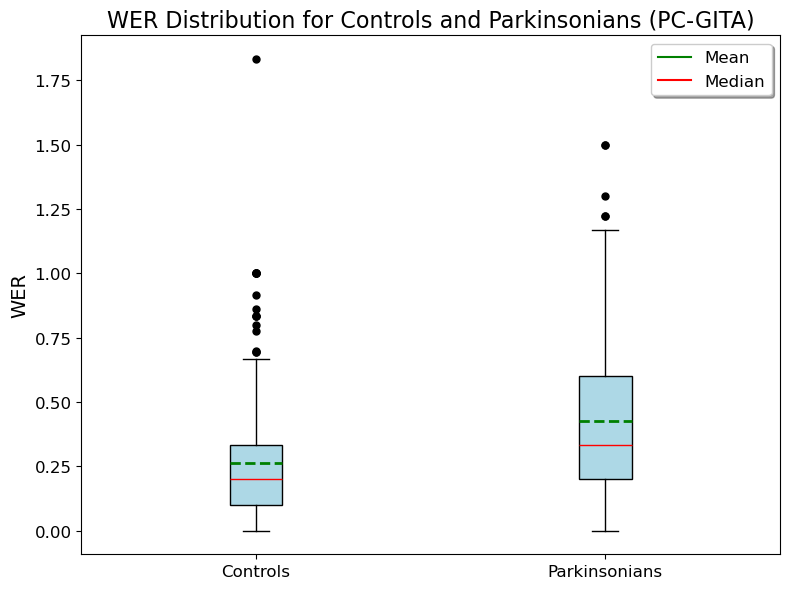

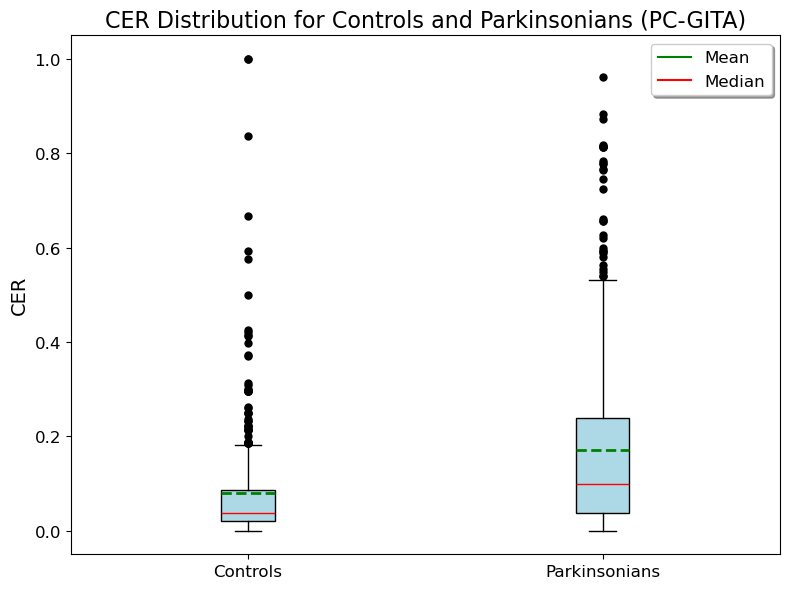


Final WER p-value: 2.756e-21
Final CER p-value: 4.363e-26


In [72]:
# Calculate and print cumulative averages (after removing outliers)
cumulative_wer_control, cumulative_wer_parkinsonian = calculate_cumulative_averages(control_wer, parkinsonian_wer, 'WER')
cumulative_cer_control, cumulative_cer_parkinsonian = calculate_cumulative_averages(control_cer, parkinsonian_cer, 'CER')

# Plot vertical boxplots for WER and CER
plot_boxplots_wer_cer(control_wer, parkinsonian_wer, control_cer, parkinsonian_cer)

# Print final p-values with 15 significant digits
print(f"\nFinal WER p-value: {wer_p_value:.3e}")
print(f"Final CER p-value: {cer_p_value:.3e}")

In [73]:
import pandas as pd  # Import pandas for creating and displaying the table

# Section 7: Calculation and visualization of cumulative results

# Calculate standard deviations for WER before outlier removal
std_wer_control = np.std(control_wer)  # Calculate standard deviation for controls WER
std_wer_parkinsonian = np.std(parkinsonian_wer)  # Calculate standard deviation for Parkinsonians WER

# Calculate standard deviations for CER
std_cer_control = np.std(control_cer)  # Calculate standard deviation for controls CER
std_cer_parkinsonian = np.std(parkinsonian_cer)  # Calculate standard deviation for Parkinsonians CER

# Calculate means and medians before outlier removal
mean_wer_control = np.mean(control_wer)
mean_wer_parkinsonian = np.mean(parkinsonian_wer)
median_wer_control = np.median(control_wer)
median_wer_parkinsonian = np.median(parkinsonian_wer)

mean_cer_control = np.mean(control_cer)
mean_cer_parkinsonian = np.mean(parkinsonian_cer)
median_cer_control = np.median(control_cer)
median_cer_parkinsonian = np.median(parkinsonian_cer)

# Create a dictionary with cumulative results, standard deviations, means, and medians
data = {
    "Metric": ["WER", "WER", "CER", "CER"],  # Metrics being analyzed
    "Group": ["Controls", "Parkinsonians", "Controls", "Parkinsonians"],  # Group classifications
    "Mean": [mean_wer_control, mean_wer_parkinsonian, mean_cer_control, mean_cer_parkinsonian],  # Means for each group
    "Standard Deviation": [std_wer_control, std_wer_parkinsonian, std_cer_control, std_cer_parkinsonian],  # Standard deviations for each group
    "Median": [median_wer_control, median_wer_parkinsonian, median_cer_control, median_cer_parkinsonian]  # Medians for each group
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(data)  # Create a DataFrame from the data dictionary

# Print final table in the console
print("\nWER and CER Results with Outliers:")
print(results_df)  # Output the DataFrame to the console

# Optionally, save the results to a CSV file
results_df.to_csv('cumulative_results_PCGITA.csv', index=False)
print("Results with outliers saved to 'cumulative_results_PCGITA.csv'.")



WER and CER Results with Outliers:
  Metric          Group      Mean  Standard Deviation    Median
0    WER       Controls  0.262383            0.199049  0.200000
1    WER  Parkinsonians  0.426954            0.297984  0.333333
2    CER       Controls  0.079534            0.109338  0.038462
3    CER  Parkinsonians  0.171728            0.182113  0.100000
Results with outliers saved to 'cumulative_results_PCGITA.csv'.
